In [ ]:
 try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    COLAB = True
    print("Note: using Google CoLab")
    %tensorflow_version 2.x
except:
    print("Note: not using Google CoLab")
    COLAB = False

Mounted at /content/drive
Note: using Google CoLab


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense 
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from keras import regularizers
import numpy as np
from PIL import Image
from tqdm import tqdm
import os 
import time
import matplotlib.pyplot as plt

In [ ]:
def load_batch(label_id):
  # Функция загружает данные одного класса из набора DCASE2017
  # Работает в зависимости от индексов меток data_train_label
  # В результате получается 2 массива: массив тренировочных данных и массив его меток

  batch_index = []
  batch_label = []
  batch_data = []
  data_train = np.load('/content/drive/My Drive/winter practice/data_train_10classes.npy', allow_pickle=False, fix_imports=False)
  data_train_label = np.load('/content/drive/My Drive/winter practice/data_train_label_10classes.npy', allow_pickle=False, fix_imports=False)

  for i in range(0, len(data_train_label)):
      if label_id == int(data_train_label[i]) and len(batch_index) != 5888:
          batch_index.append(i)

  for i in batch_index:
      batch_data.append(data_train[i])

  return np.array(batch_data)

FolderForExperiments = '/FolderForExperiments'
NextFolder = '/0'
ADDITIONAL_FOLDER = FolderForExperiments + NextFolder
folder = 'Gan models (after 24.04.2021)' + ADDITIONAL_FOLDER

F = 'Gan models (after 24.04.2021)/FolderForExperiments/0'

label = 3
IMAGE_CHANNELS = 2
SEED_SIZE = 100
BATCH_SIZE = 256
BUFFER_SIZE = 12000
epochs = 110

#speeds of labels 0, 1
#generator_optimizer = tf.keras.optimizers.Adam(2e-4,0.5)
#discriminator_optimizer = tf.keras.optimizers.Adam(1.1e-4,0.15,0.98)

#speeds of labels 2, 3
generator_optimizer = tf.keras.optimizers.Adam(2.5e-4,0.6)
discriminator_optimizer = tf.keras.optimizers.Adam(0.8e-4,0.05,0.98)


training_data = load_batch(label)
training_data = (training_data - 127.5) / 127.5 # Normalize the images to [-1, 1]

print(training_data.shape)
print(type(training_data))
print(training_data.shape[0])

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(training_data).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

(5888, 128, 42, 2)
<class 'numpy.ndarray'>
5888


In [ ]:
def build_generator(seed_size, channels):
    model = Sequential()

    model.add(Dense(128*42*2,activation="relu",input_dim=seed_size))
    model.add(Reshape((8,1,1344)))
    model.add(BatchNormalization(momentum=0.99))

    model.add(UpSampling2D((2,2)))
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(UpSampling2D((2,3)))
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
   
    model.add(UpSampling2D((2,1)))
    model.add(Conv2D(128,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(UpSampling2D((2,7)))
    model.add(Conv2D(128,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(Conv2D(channels,kernel_size=3,padding="same"))
    model.add(Activation("tanh"))

    return model
    

def build_discriminator(image_shape):
    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=image_shape, 
                     padding="same"))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.2))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same", 
                     kernel_regularizer = regularizers.l2(0.00015)))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.2))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same", 
                     kernel_regularizer = regularizers.l2(0.00015)))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.2))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same", 
                     kernel_regularizer = regularizers.l2(0.00015)))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.2))
    model.add(Conv2D(512, kernel_size=3, strides=1, padding="same", 
                     kernel_regularizer = regularizers.l2(0.00015)))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

(1, 128, 42, 2)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


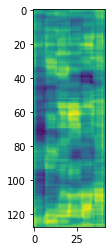

In [ ]:
image_shape = (128,42,2)
discriminator = build_discriminator(image_shape)
decision = discriminator(generated_image)
print (decision)


In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
#generator_optimizer = tf.keras.optimizers.Adam(2e-4,0.5)
#discriminator_optimizer = tf.keras.optimizers.Adam(1.1e-4,0.1,0.98)
#discriminator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)

In [ ]:
@tf.function
def train_step(images):
  seed = tf.random.normal([BATCH_SIZE, SEED_SIZE])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(seed, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
    

    gradients_of_generator = gen_tape.gradient(\
        gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(\
        disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(
        gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(
        gradients_of_discriminator, 
        discriminator.trainable_variables))
  return gen_loss,disc_loss

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

In [ ]:
def train(dataset, epochs):
 # fixed_seed = np.random.normal(0, 1, (28, SEED_SIZE))
  start = time.time()

  g_loss_lits = []
  d_loss_lits = []
  decision_list = []
  print(f'Обучение генератора для класса с меткой {label}')

  for epoch in range(epochs):
    epoch_start = time.time()

    gen_loss_list = []
    disc_loss_list = []

    for image_batch in dataset:
      t = train_step(image_batch)
      gen_loss_list.append(t[0])
      disc_loss_list.append(t[1])

    g_loss = sum(gen_loss_list) / len(gen_loss_list)
    d_loss = sum(disc_loss_list) / len(disc_loss_list)

    d_loss_lits.append(np.float(d_loss))
    g_loss_lits.append(np.float(g_loss))

    checking_SEED = SEED_SIZE
    checking_noise = tf.random.normal([1, checking_SEED])
    checking_generated_image = generator(checking_noise, training=False)
    decision = discriminator(checking_generated_image, training=False)
    decision_list.append(np.float(decision[0][0]*100))

    if epoch % 1 == 0:

      epoch_elapsed = time.time()-epoch_start
      print (f'Epoch {epoch+1},   gen loss = {round(np.float(g_loss),3)},  disc loss = {round(np.float(d_loss),3)},    decision = {round(np.float(decision),3)}',
              {hms_string(epoch_elapsed)})
   # save_images(epoch,fixed_seed)
      #print (decision)  

  elapsed = time.time()-start
  print (f'Training time: {hms_string(elapsed)}')

  return g_loss_lits, d_loss_lits, decision_list

  

In [ ]:
g_loss_lits, d_loss_lits, decision_list = train(train_dataset, epochs)

Обучение генератора для класса с меткой 3
Epoch 1,   gen loss = 1.909,  disc loss = 1.34,    decision = 0.997 {'0:00:23.24'}
Epoch 2,   gen loss = 0.983,  disc loss = 1.895,    decision = 0.955 {'0:00:13.48'}
Epoch 3,   gen loss = 0.979,  disc loss = 1.832,    decision = 0.986 {'0:00:13.42'}
Epoch 4,   gen loss = 0.907,  disc loss = 1.848,    decision = 0.91 {'0:00:13.54'}
Epoch 5,   gen loss = 0.925,  disc loss = 1.796,    decision = 0.967 {'0:00:13.70'}
Epoch 6,   gen loss = 0.873,  disc loss = 1.788,    decision = 0.844 {'0:00:13.79'}
Epoch 7,   gen loss = 0.902,  disc loss = 1.773,    decision = 0.922 {'0:00:13.71'}
Epoch 8,   gen loss = 0.857,  disc loss = 1.74,    decision = 0.756 {'0:00:13.70'}
Epoch 9,   gen loss = 0.876,  disc loss = 1.706,    decision = 0.858 {'0:00:13.67'}
Epoch 10,   gen loss = 0.852,  disc loss = 1.715,    decision = 0.654 {'0:00:13.58'}
Epoch 11,   gen loss = 0.89,  disc loss = 1.723,    decision = 0.796 {'0:00:13.59'}
Epoch 12,   gen loss = 0.836,  disc 

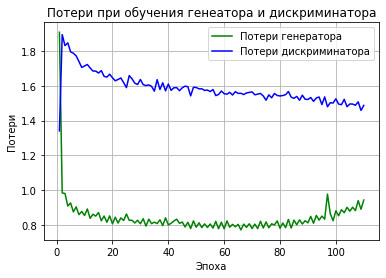

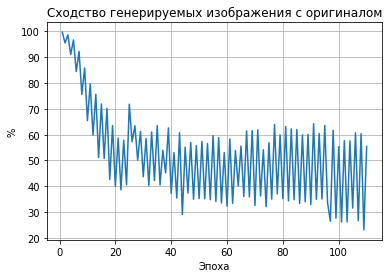

In [ ]:
  from matplotlib.pyplot import savefig
  
  epochs_array = []
  for i in range(0, epochs):
    epochs_array.append(i+1)

  plt.plot(epochs_array, g_loss_lits, 'g', label = 'Потери генератора' )
  plt.plot(epochs_array, d_loss_lits, 'b', label = 'Потери дискриминатора')
  plt.title('Потери при обучения генеатора и дискриминатора')
  plt.xlabel('Эпоха')
  plt.ylabel('Потери')
  plt.grid()
  plt.legend()
  savefig(f'/content/drive/My Drive/winter practice/{folder}/{label}/gen,disc losses - class #{label}.png')
  plt.show()

  plt.clf()

  plt.plot(epochs_array, decision_list )
  plt.title('Сходство генерируемых изображения с оригиналом')
  plt.xlabel('Эпоха')
  plt.ylabel('%')
  plt.grid()
  savefig(f'/content/drive/My Drive/winter practice/{folder}/{label}/images quality - class #{label}.png')
  plt.show()

tf.Tensor([[0.5471775]], shape=(1, 1), dtype=float32)
(1, 128, 42, 2)


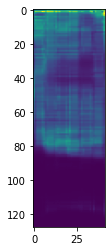

In [ ]:
noise = tf.random.normal([1, SEED_SIZE])
generated_image = generator(noise, training=False)
decision = discriminator(generated_image)
print (decision)
print(generated_image.shape)
plt.imshow(generated_image[0, :, :, 0])

In [ ]:
DATA_PATH1 = f'/content/drive/My Drive/winter practice/{folder}/{label}'
DATA_PATH2 = f'/content/drive/My Drive/winter practice/{folder}/{label}'

generator.save(os.path.join(DATA_PATH1,f"generator-[{label}].h5"))
discriminator.save(DATA_PATH2,f"discriminator-[{label}].h5")

INFO:tensorflow:Assets written to: /content/drive/My Drive/winter practice/Gan models (after 24.04.2021)/FolderForExperiments/0/3/assets


In [ ]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    COLAB = True
    print("Note: using Google CoLab")
    %tensorflow_version 2.x
except:
    print("Note: not using Google CoLab")
    COLAB = False



Mounted at /content/drive
Note: using Google CoLab


In [ ]:
def data_generator(count, label, SEED_SIZE):
  start = time.time()

  data_case = []
  label_case = []
  SEED_SIZE = SEED_SIZE
  n = 0

  while n != count:
    noise = tf.random.normal([1, SEED_SIZE])
    generated_image = generator(noise, training=False)
    data_case.append(generated_image[0])   
    label_case.append(label) 
    n+=1

  elapsed = time.time()-start
  print (f'Generating time: {hms_string(elapsed)}')

  return data_case, label_case

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


In [ ]:
from tensorflow.keras.models import load_model
import os
import datetime as dt
import six
import h5py

generated_data, label_case = data_generator(5888, 0, SEED_SIZE=SEED_SIZE)

print(np.array(generated_data).shape)
print(np.array(label_case).shape)

with open(f'/content/drive/My Drive/winter practice/{folder}/{label}/data_{label}.npy', 'wb') as f:
    np.save(f, np.array(generated_data), allow_pickle = False , fix_imports = False)
    print(f'Fragments saved successfully data_{label}.npy')
    
with open(f'/content/drive/My Drive/winter practice/{folder}/{label}/label_{label}.npy', 'wb') as f:
    np.save(f, np.array(label_case), allow_pickle = False , fix_imports = False)
    print(f'Labels saved successfully in file label_{label}.npy')

Generating time: 0:00:39.99
(5888, 128, 42, 2)
(5888,)
Fragments saved successfully data_3.npy
Labels saved successfully in file label_3.npy


In [ ]:
#epochs2 = 30
#g_loss_lits2, d_loss_lits2, decision_list2 = train(train_dataset, epochs2)


In [ ]:
#epochs3 = 30
#g_loss_lits3, d_loss_lits3, decision_list3 = train(train_dataset, epochs3)